In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from scipy.optimize import minimize
from skimage.transform import resize

In [27]:
def load_image(path):
    image_path = "./images/" + path
    img = cv2.imread(image_path)    
    return img

In [28]:
def stack_images(images, type, titles = None):


    fig, axes = plt.subplots(1, len(images), figsize=(10*len(images), 8))

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.axis("off")
        if titles is not None:
            ax.set_title(title, fontsize=14)

    plt.subplots_adjust(wspace=0.2, hspace=0.2)  # padding between images
    plt.savefig(f"./outputs/{type}.png", dpi=300, bbox_inches="tight")
    plt.show()

In [29]:
def stack_images(images, type, titles = None):
    if not isinstance(images[0], list):
        images = [images]

    rows = len(images)
    cols = len(images[0])

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))

    # Flatten axes for consistent indexing
    if rows == 1 and cols == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    elif cols == 1:
        axes = [[ax] for ax in axes]

    for r in range(rows):
        for c in range(cols):
            axes[r][c].imshow(images[r][c])
            axes[r][c].axis("off")

            # Apply titles only if provided and for 1D stack
            if titles is not None and rows == 1:
                axes[r][c].set_title(titles[c], fontsize=14)

    plt.tight_layout()
    plt.savefig(f"./outputs/{type}.png", dpi=300, bbox_inches="tight")
    plt.show()

In [30]:
def gaussian_kernel(size, sigma):
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel

In [31]:
def convolution2d(image, kernel):
    if image.ndim == 2:
        image = image[..., np.newaxis]

    image_height, image_width, channels = image.shape
    kernel_height, kernel_width = kernel.shape

    pad_h = kernel_height // 2
    pad_w = kernel_width // 2

    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='edge')
    convolved = np.zeros_like(image, dtype=np.float64)

    for c in range(channels):  
        for i in range(image_height):
            for j in range(image_width):
                region = padded_image[i:i + kernel_height, j:j + kernel_width, c]
                convolved[i, j, c] = np.sum(region * kernel)

    convolved = np.clip(convolved, 0, 255)
    return convolved.astype(np.uint8)

In [32]:
def downsample(img, factor, kernel_size, sigma):
    H, W, C = img.shape
    if kernel_size > 0:
        img = convolution2d(img, gaussian_kernel(kernel_size, sigma))
    downsampled_img = np.zeros((H // factor, W // factor, C), dtype=img.dtype)
    for c in range(C):
        m = 0
        for i in range(0, H // factor):
            n = 0
            for j in range(0, W // factor):
                downsampled_img[i, j, c] = img[m, n, c]
                n += factor
            m += factor
    return downsampled_img

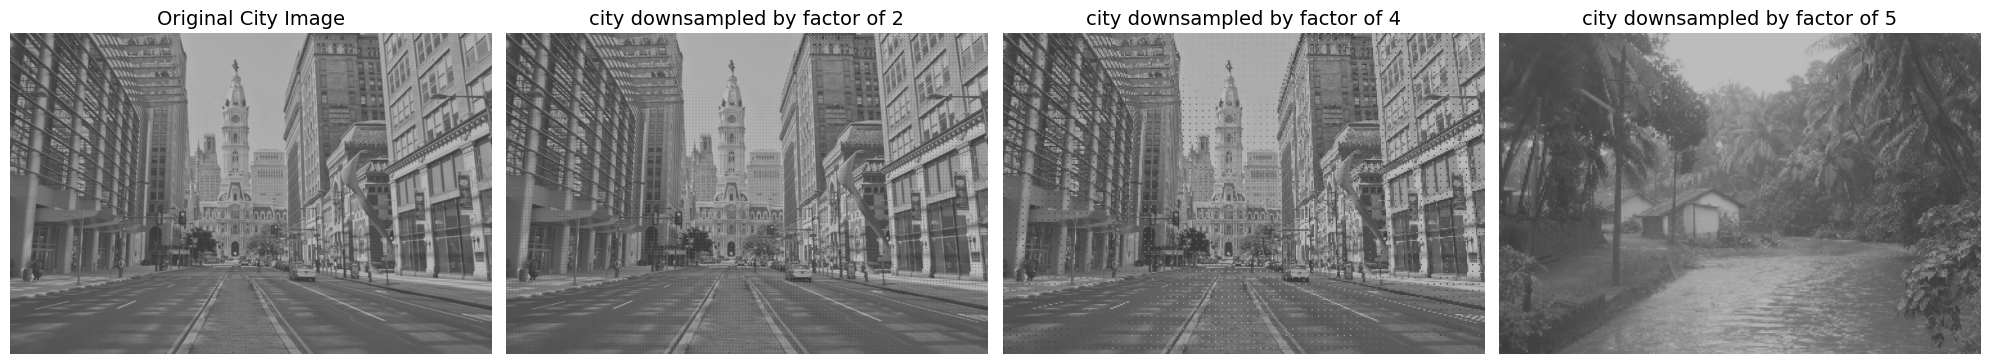

In [33]:

img_name = "city"
img = load_image(img_name + ".png")
titles, imgs = ["Original City Image"], [img]
for factor in [2, 4, 5]:
    imgs.append(downsample(img, factor, 0, 1))
    titles.append(f"{img_name} downsampled by factor of {factor}")
stack_images(imgs, "Downsample", titles)

In [71]:
def downsampling_using_library_functions(img, factor):
    return resize(img, 
                  (img.shape[0]//factor, img.shape[1]//factor), 
                  anti_aliasing=True)
    
   

In [72]:
def mse_loss(i1, i2):
    return np.mean((i1 - i2) ** 2)

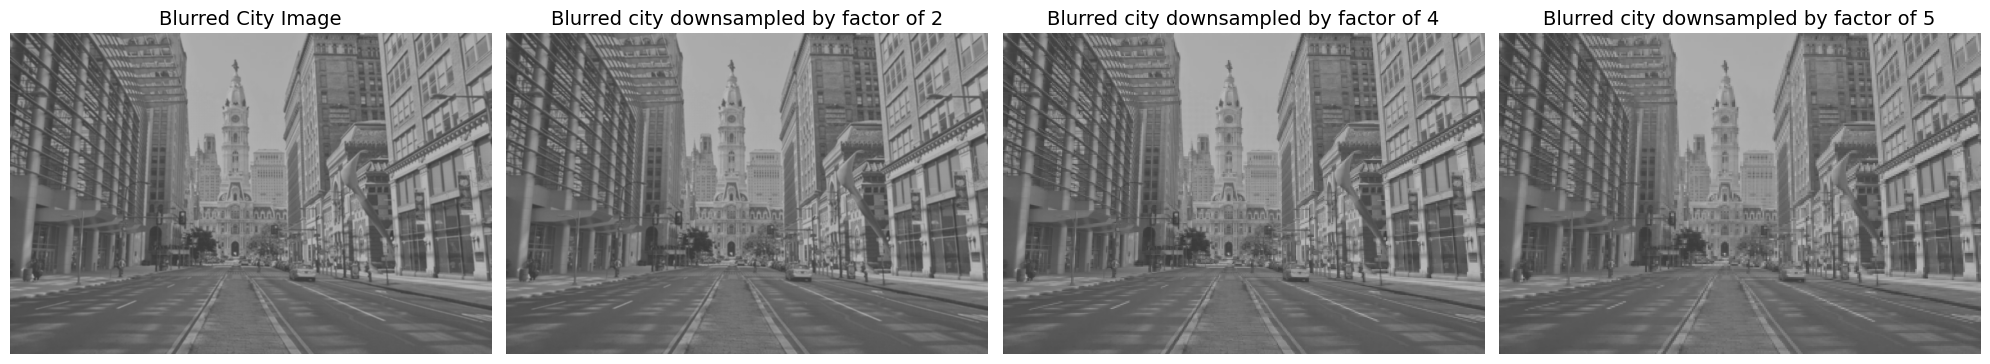

In [73]:
img_name = "city"
img = load_image(img_name + ".png")
kernel_size, sigma = 5, 2
blurred_img = convolution2d(img, gaussian_kernel(kernel_size, sigma))
titles, imgs = ["Blurred City Image"], [blurred_img]
compare_titles, compare = [], []
for factor in [2, 4, 5]:
    downsampled_img = downsample(img, factor, kernel_size, sigma)
    downsampled_img_using_library = downsampling_using_library_functions(img, factor)
    mse = mse_loss(downsampled_img, downsampled_img_using_library)
    compare_titles.append(f"MSE for downsampling by {factor}: {mse}")
    compare.append([downsampled_img, downsampled_img_using_library])
    imgs.append(downsampled_img)
    titles.append(f"Blurred {img_name} downsampled by factor of {factor}")
stack_images(imgs, "Downsampling_after_blurring", titles)

### Library Function

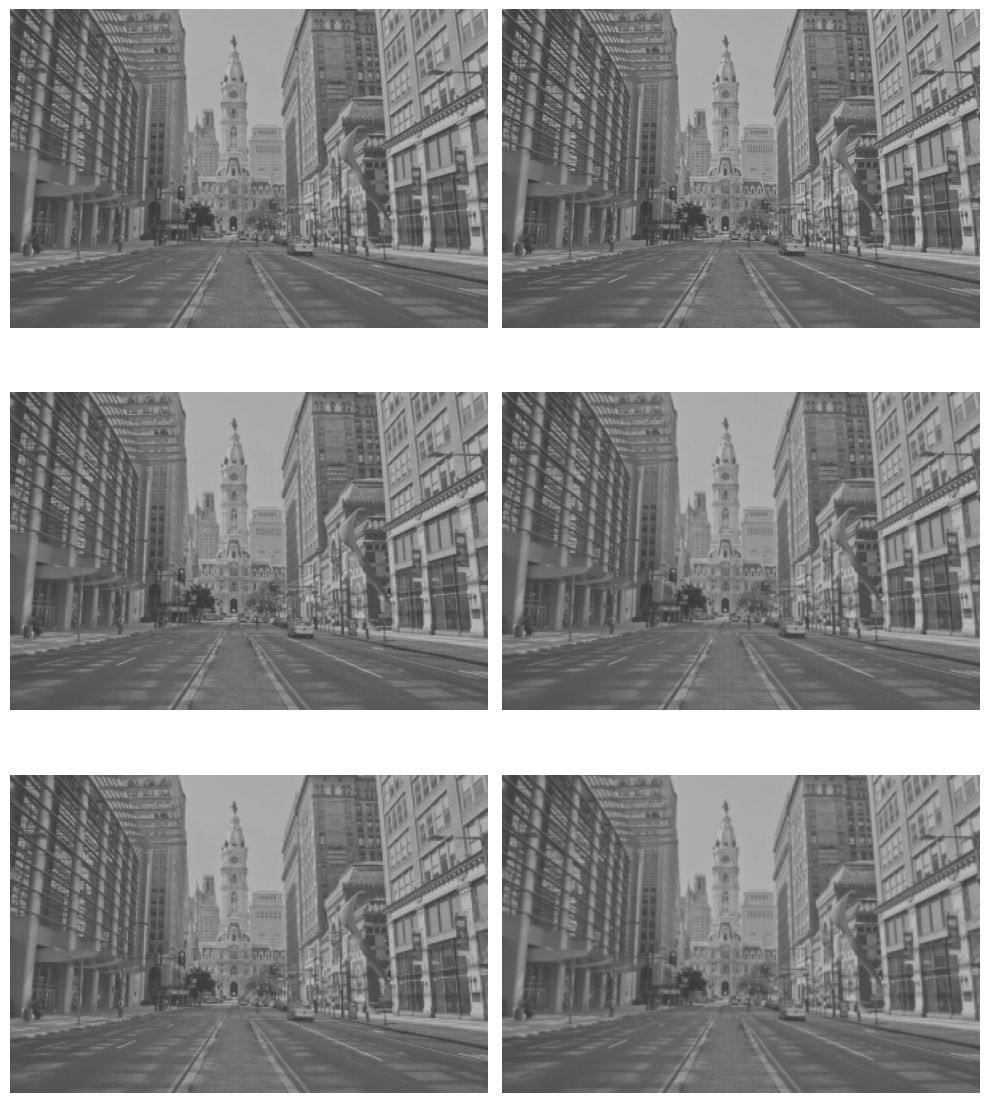

In [74]:
stack_images(compare, "Downsampling_after_blurring")

In [75]:
print("\n".join(compare_titles))

MSE for downsampling by 2: 14373.237049644715
MSE for downsampling by 4: 14376.343889201347
MSE for downsampling by 5: 14307.909648172561


In [ ]:
def mse_loss(params, factor, img, ref):
    k, sigma = params
    if k <= 1 or sigma <= 0:
        return 1e6  # invalid values → high penalty
    
    out = downsample(img, factor, k, sigma)
    # print(out)
    # ref = downsampling_using_library_functions(img, factor, int(k), sigma)
    mean = np.mean((out - ref)**2)
    print(params, mean)
    return mean

In [ ]:
def find_optimal_kernel(img, factor):
    ref = downsampling_using_library_functions(img, factor)
    result = minimize(
        mse_loss,
        x0=[11, 4],        
        args=(factor, img),
        bounds=[(3, 11), (0.1, 5)],
        method='L-BFGS-B'
    )
    
    best_k = int(result.x[0])
    best_sigma = result.x[1]
    best_mse = result.fun
    
    return best_k, best_sigma, best_mse

In [78]:
img_name = "city"
factor = 5
img = load_image(img_name + ".png")
results = find_optimal_kernel(img, factor)

TypeError: downsampling_using_library_functions() takes 2 positional arguments but 4 were given

In [62]:
print(results)

(7, 2.0, 38.15518333333333)
